## Demo for train an RNN with our Embeddings/Tokenizers

In [1]:
GLOVE_PATH = "C:\\Users\\Administrator\\Desktop\\glove\\glove.6B.100d.txt" # change to your path
EMBED_DIM = 100 # No need to change

In [2]:
from transformers import get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset 
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from Embeddings import GloveEmbedding, GloveTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# set seeds
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(114514)

In [4]:
# import tokenizer
tokenizer = GloveTokenizer(glove_file_path=GLOVE_PATH)
embedding = GloveEmbedding(
    glove_file_path = GLOVE_PATH, 
    trainable = True # False for part 2 to disable the Embedding training
)

In [5]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding, hidden_size, embed_size, bidirectional, num_rnn_layer, dropout_rate, layer_norm):
        super(SentimentRNN, self).__init__()
        self.embedding = embedding  # pass pretrained embedding in
        self.bidirectional = bidirectional
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True, num_layers = num_rnn_layer, bidirectional=bidirectional, dropout = dropout_rate)
        
        # if bidirectional, the output hidden size is double
        self.hidden_size = hidden_size * 2 if bidirectional else hidden_size
        
        # MLP
        if not layer_norm:
            self.output_layer = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1),  # output dimension is 1 (sigmoid is in BCELossWithLogits, so no sigmoid here. This will get better result)
            )
        else:
            self.output_layer = nn.Sequential(
                nn.LayerNorm(self.hidden_size),
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.LayerNorm(self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1), 
            )
        
    def forward(self, input_ids, attention_mask):
        '''
        This method is designed for biLSTM/GRU/RNN. For LSTM/GRU/RNN for only one direction, just take hidden as the rnn output.
        RNN - hidden -> MLP --> outcome
        '''
        # embed the input
        embedded = self.embedding(input_ids)  # [batch_size, seq_length, embedding_dim]
        
        # feed forward
        output, hidden = self.rnn(embedded) # we don't need encoder so we only keep the output

        # make attention mask from [batch_size, seq_length] to [batch_size, seq_length, 1] as the same dimension as rnn
        attention_mask = attention_mask.unsqueeze(-1)  # [batch_size, seq_length, 1]

        # use attention mask to mask the output, ignore the padding embedding vector, only add the valid embedding vector 
        masked_output = output * attention_mask

        # sum up all the valid output
        summed_output = masked_output.sum(dim=1)  # [batch_size, hidden_size]

        logits = self.output_layer(summed_output)
        
        return logits  # The output is [batch_size, 1]

In [6]:
# import datasets

train_df = pd.read_csv("./preprocessed_dataset/train_norm.csv").iloc[:,1:]
validation_df = pd.read_csv("./preprocessed_dataset/validation_norm.csv").iloc[:,1:]
test_df = pd.read_csv("./preprocessed_dataset/test_norm.csv").iloc[:,1:]
train_df

,text,label
0,the rock is destined to be the 21st centurys n...,1
1,the gorgeously elaborate continuation of the ...,1
2,effective but tootepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,emerges as something rare an issue movie that...,1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young womans br...,0
8528,interminably bleak to say nothing of boring,0


In [7]:
# try to use tokenizer api
tokenizer.encode(["hello world", "how are you"], return_tensors = "pt") # insist to return pytorch

{'input_ids': tensor([[13077,    87,     0],
         [  199,    34,    83]]),
 'attention_mask': tensor([[1, 1, 0],
         [1, 1, 1]])}

In [8]:
# define dataset and data loader
from typing import Any


class CustomizeDataset(Dataset):
    def __init__(
            self,
            df : pd.DataFrame
        ) -> None:
        super().__init__()
        self.df = df
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(
            self, 
            index : int
        ) -> dict:
        
        inputs = self.df.iloc[index,0] # 0 is text
        label = self.df.iloc[index, 1] # 1 is label
        
        return {
            "input_str" : inputs, # output a string
            "label" : label # output a label
        }
        
# collater function (used for dynamic padding to save memory)
class Collater:
    def __init__(
            self,
            tokenizer : GloveTokenizer
        ) -> None:
        self.tokenizer = tokenizer 
    
    def __call__(
            self,
            instances : list # a list of string
        ) -> Any:
        # __call__ is for function-like object
        input_str_list = [instance["input_str"] for instance in instances]
        input_dict = tokenizer.encode(input_str_list, return_tensors = "pt") # return pytorch tensor
        input_ids = input_dict["input_ids"]
        attention_mask = input_dict["attention_mask"]
        label = [torch.tensor(instance["label"], dtype = torch.int64) for instance in instances]

        return {
            "input_ids": input_ids,
            "label": torch.tensor(label),
            "attention_mask": attention_mask # mask the pad position
        }

In [9]:
# Hyper paramaters
dropout_rate = 0.1
num_rnn_layer = 2
hidden_dim = 256

val_steps = 100 # compute validation error every n step

num_train_epochs = 3

batch_size = 32
lr = 8e-5
weight_decay = 1e-5


warmup_ratio=0.05
max_grad_norm = 2.0

In [10]:
# create dataset and data loader

collate_fn = Collater(tokenizer)

train_ds = CustomizeDataset(
    df = train_df
)

train_loader = DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    collate_fn = collate_fn,
    shuffle = True
)

val_ds = CustomizeDataset(
    df = validation_df
)

val_loader = DataLoader(
    dataset = val_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

test_ds = CustomizeDataset(
    df = test_df
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

In [11]:
# compute warmup status
num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:801, warm up: 40


In [12]:
# Set optimizer, loss_fn and so on

cls_model = SentimentRNN(
    embedding = embedding, 
    hidden_size = hidden_dim, 
    embed_size = EMBED_DIM, 
    bidirectional = True, #  False for part 2
    num_rnn_layer = num_rnn_layer,
    dropout_rate = dropout_rate,
    layer_norm = True # set if you need layer norm
)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = AdamW(
    params = cls_model.parameters(),
    lr = lr,
    weight_decay = weight_decay
)

scheduler  = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps = num_training_steps
)

In [13]:
# compute accuracy for wach data loader

def compute_accuracy(data_loader: DataLoader) -> float:
    
    cls_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

def compute_loss(data_loader: DataLoader) -> float:
    total_loss = 0
    cls_model.eval()
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model.forward(input_ids, attention_mask)
            loss = loss_fn.forward(
                input = logits,
                target = labels
            )
            
            total_loss += loss.detach().cpu()
            
        total_loss /= len(val_loader)
        
        return total_loss
    

In [14]:
# Training loop

cls_model.to(device)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

for epoch in range(num_train_epochs):
    
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()

        # Gradient clip (important for RNN, not necessary for LSTM/GRU/conv1d)
        torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss = loss.detach().cpu()
        
        print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
        
        
        train_losses.append(vis_loss)
        
        if (step + 1) % val_steps == 0 or step == 0:
            # compute validation every "val_steps"
           
            cls_model.eval()
            val_loss = compute_loss(val_loader)
            val_acc = compute_accuracy(val_loader)
            
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            print(f"[{step + 1}/{num_training_steps}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
        
        step += 1
    
    

[1/801] train loss: [0.6737] (epoch [1/3])
[1/801] validation loss: [0.7086] validation accuracy: [0.5009]
[2/801] train loss: [0.7035] (epoch [1/3])
[3/801] train loss: [0.6970] (epoch [1/3])
[4/801] train loss: [0.7145] (epoch [1/3])
[5/801] train loss: [0.6876] (epoch [1/3])
[6/801] train loss: [0.7180] (epoch [1/3])
[7/801] train loss: [0.7253] (epoch [1/3])
[8/801] train loss: [0.6981] (epoch [1/3])
[9/801] train loss: [0.6838] (epoch [1/3])
[10/801] train loss: [0.6941] (epoch [1/3])
[11/801] train loss: [0.6886] (epoch [1/3])
[12/801] train loss: [0.6622] (epoch [1/3])
[13/801] train loss: [0.6962] (epoch [1/3])
[14/801] train loss: [0.6614] (epoch [1/3])
[15/801] train loss: [0.7097] (epoch [1/3])
[16/801] train loss: [0.7212] (epoch [1/3])
[17/801] train loss: [0.6685] (epoch [1/3])
[18/801] train loss: [0.6937] (epoch [1/3])
[19/801] train loss: [0.7386] (epoch [1/3])
[20/801] train loss: [0.6893] (epoch [1/3])
[21/801] train loss: [0.7078] (epoch [1/3])
[22/801] train loss: 

In [15]:
# test loss
cls_model.eval()

test_loss = compute_loss(test_loader)
    
test_acc = compute_accuracy(test_loader)

print(f"Test Loss: [{test_loss:.4f}]\nTest accuracy: [{test_acc:.4f}]")

Test Loss: [0.5274]
Test accuracy: [0.7420]


In [16]:
test_word = "It is the law of Inverse Relevance: the less you intend to do about something, the more you have to keep talking about it."

toks = tokenizer.encode(test_word, return_tensors="pt")
F.sigmoid(cls_model.forward(toks["input_ids"].to(device), toks["attention_mask"].to(device))).detach().cpu().item()

0.5122587084770203

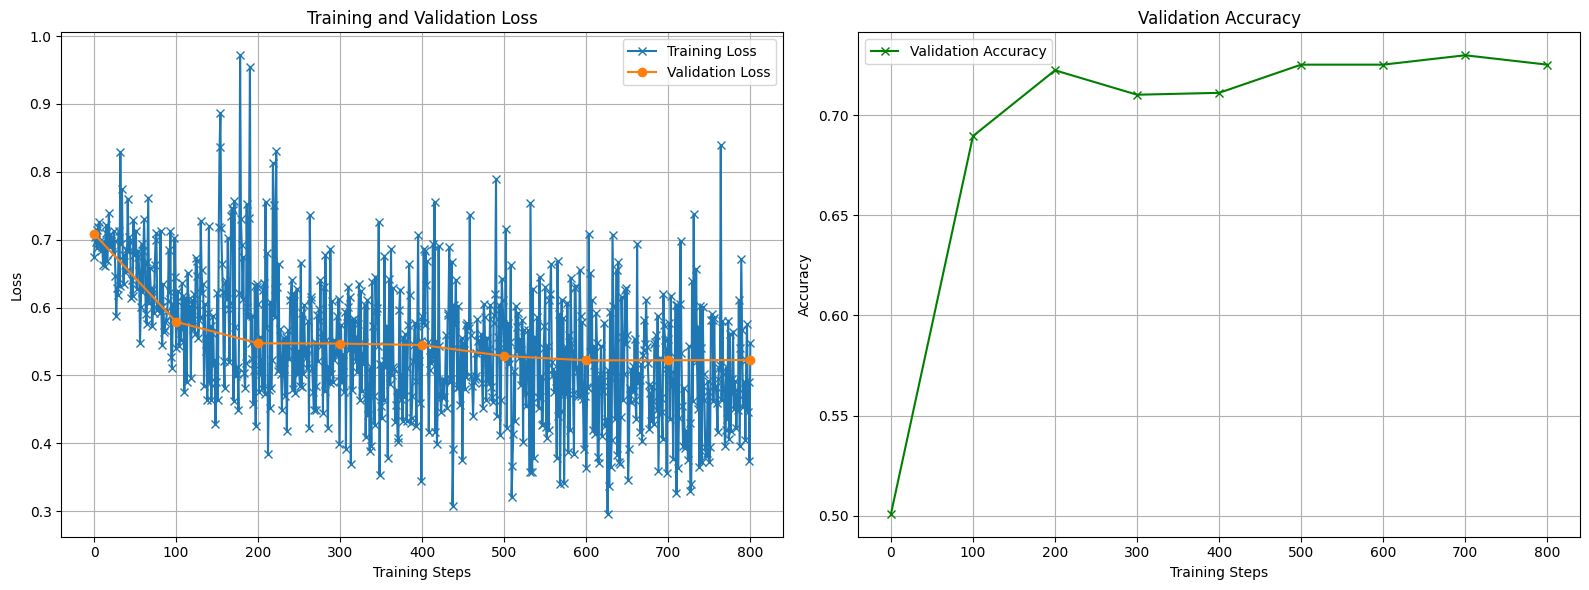

In [17]:
# visualization 1: train / val curve

val_steps = [i * val_steps for i in range(len(val_losses))]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# loss
ax1.plot(train_losses, label='Training Loss', marker='x')
ax1.plot(val_steps, val_losses, label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# acc
ax2.plot(val_steps, val_accs, label='Validation Accuracy', color='green', marker='x')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()


plt.tight_layout()
plt.show()

In [18]:
# compute predictions and labels for confusion matrix computing
def compute_pedictions_and_labels(
        model : nn.Module, 
        test_loader : DataLoader, 
        device : torch.device
    ) -> tuple:
    
    model.to(device)
    
    model.eval()
    
    # Lists to store all predictions and actual labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    return all_predictions, all_labels

all_predictions, all_labels = compute_pedictions_and_labels(cls_model, test_loader, device)

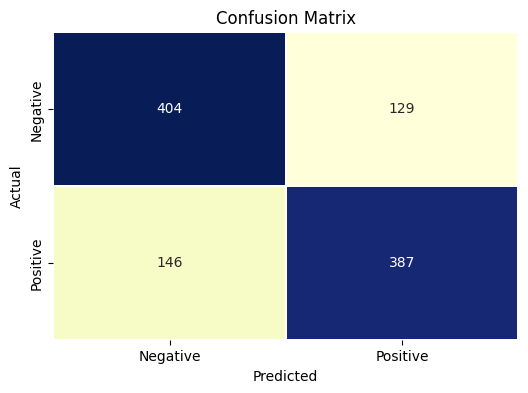

In [19]:
# visualization 2: confusion matrix

def plot_confusion(
        all_predictions : list, 
        all_labels : list
    ) -> None:      
            
    cm = confusion_matrix(all_labels, all_predictions) # from sklearn
            
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.2, cmap="YlGnBu", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
    plt.show()
    
plot_confusion(all_predictions, all_labels)

In [20]:
def plot_f1_score(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    f1 = f1_score(all_labels, all_predictions)
    print("F1 Score: ", f1)
    
plot_f1_score(all_predictions, all_labels)

F1 Score:  0.7378455672068637


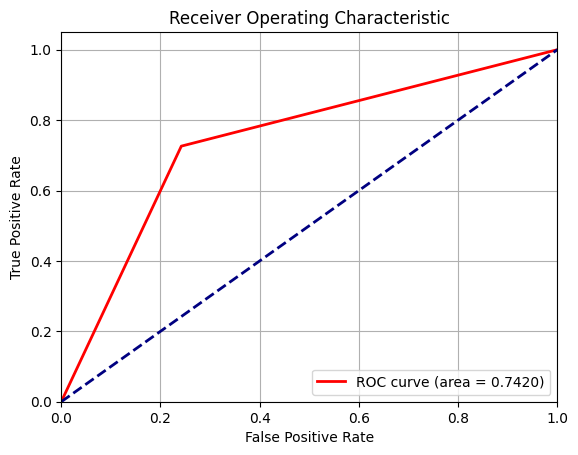

In [21]:
def plot_roc_curve(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label=f"ROC curve (area = {roc_auc:0.4f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
plot_roc_curve(all_predictions, all_labels)

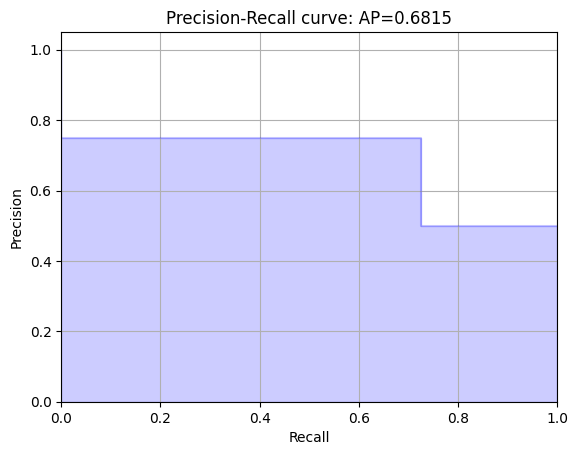

In [22]:
def plot_precision_recall_curve(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
    average_precision = average_precision_score(all_labels, all_predictions)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision-Recall curve: AP={average_precision:.4f}")
    plt.grid(True)
    plt.show()
    
plot_precision_recall_curve(all_predictions, all_labels)